Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StanModels

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path_s("..", "scripts", "13")
cd(ProjDir)

### snippet 13.1

In [3]:
wd = CSV.read(rel_path("..", "data", "UCBadmit.csv"), delim=';');
df = convert(DataFrame, wd);

Preprocess data

In [4]:
df[:admit] = convert(Vector{Int}, df[:admit])
df[:applications] = convert(Vector{Int}, df[:applications])
df[:male] = [(df[:gender][i] == "male" ? 1 : 0) for i in 1:size(df, 1)];
df[:dept_id] = [Int(df[:dept][i][1])-64 for i in 1:size(df, 1)];
first(df, 5)

m13_2 = "
  data{
      int N;
      int N_depts;
      int applications[N];
      int admit[N];
      real male[N];
      int dept_id[N];
  }
  parameters{
      vector[N_depts] a_dept;
      real a;
      real bm;
      real<lower=0> sigma_dept;
  }
  model{
      vector[N] p;
      sigma_dept ~ cauchy( 0 , 2 );
      bm ~ normal( 0 , 1 );
      a ~ normal( 0 , 10 );
      a_dept ~ normal( a , sigma_dept );
      for ( i in 1:N ) {
          p[i] = a_dept[dept_id[i]] + bm * male[i];
          p[i] = inv_logit(p[i]);
      }
      admit ~ binomial( applications , p );
  }
";

Define the Stanmodel and set the output format to :mcmcchains.

In [5]:
stanmodel = Stanmodel(name="m13_2", model=m13_2,
monitors=["a", "bm", "sigma_dept", "a_dept.1", "a_dept.2", "a_dept.3",
"a_dept.4", "a_dept.5", "a_dept.6"],
output_format=:mcmcchains);


File /Users/rob/.julia/dev/StanModels/scripts/13/tmp/m13_2.stan will be updated.



Input data for cmdstan

In [6]:
ucdata = Dict("N" => size(df, 1), "N_depts" => maximum(df[:dept_id]), "admit" => df[:admit],
"applications" => df[:applications],  "dept_id"=> df[:dept_id], "male" => df[:male]);

Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, ucdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)

2-element Array{ChainDataFrame,1}

Summary Statistics

│ Row │ parameters │ mean       │ std       │ naive_se   │ mcse       │ ess    │
│     │ Symbol     │ Float64    │ Float64   │ Float64    │ Float64    │ Any    │
├─────┼────────────┼────────────┼───────────┼────────────┼────────────┼────────┤
│ 1   │ a          │ -0.598402  │ 0.662119  │ 0.010469   │ 0.0128071  │ 4000.0 │
│ 2   │ a_dept.1   │ 0.67351    │ 0.0958767 │ 0.00151594 │ 0.00202712 │ 4000.0 │
│ 3   │ a_dept.2   │ 0.62552    │ 0.112226  │ 0.00177444 │ 0.00240193 │ 4000.0 │
│ 4   │ a_dept.3   │ -0.58455   │ 0.0745533 │ 0.00117879 │ 0.00123478 │ 4000.0 │
│ 5   │ a_dept.4   │ -0.61795   │ 0.0846592 │ 0.00133858 │ 0.00153714 │ 4000.0 │
│ 6   │ a_dept.5   │ -1.05907   │ 0.0981223 │ 0.00155145 │ 0.00158372 │ 4000.0 │
│ 7   │ a_dept.6   │ -2.61329   │ 0.159606  │ 0.00252359 │ 0.00275634 │ 4000.0 │
│ 8   │ bm         │ -0.0924225 │ 0.0779619 │ 0.00123269 │ 0.00180041 │ 4000.0 │
│ 9   │ sigma_dept │ 1.48898    │ 0.575888  │ 0.009105

Plot the density of posterior draws

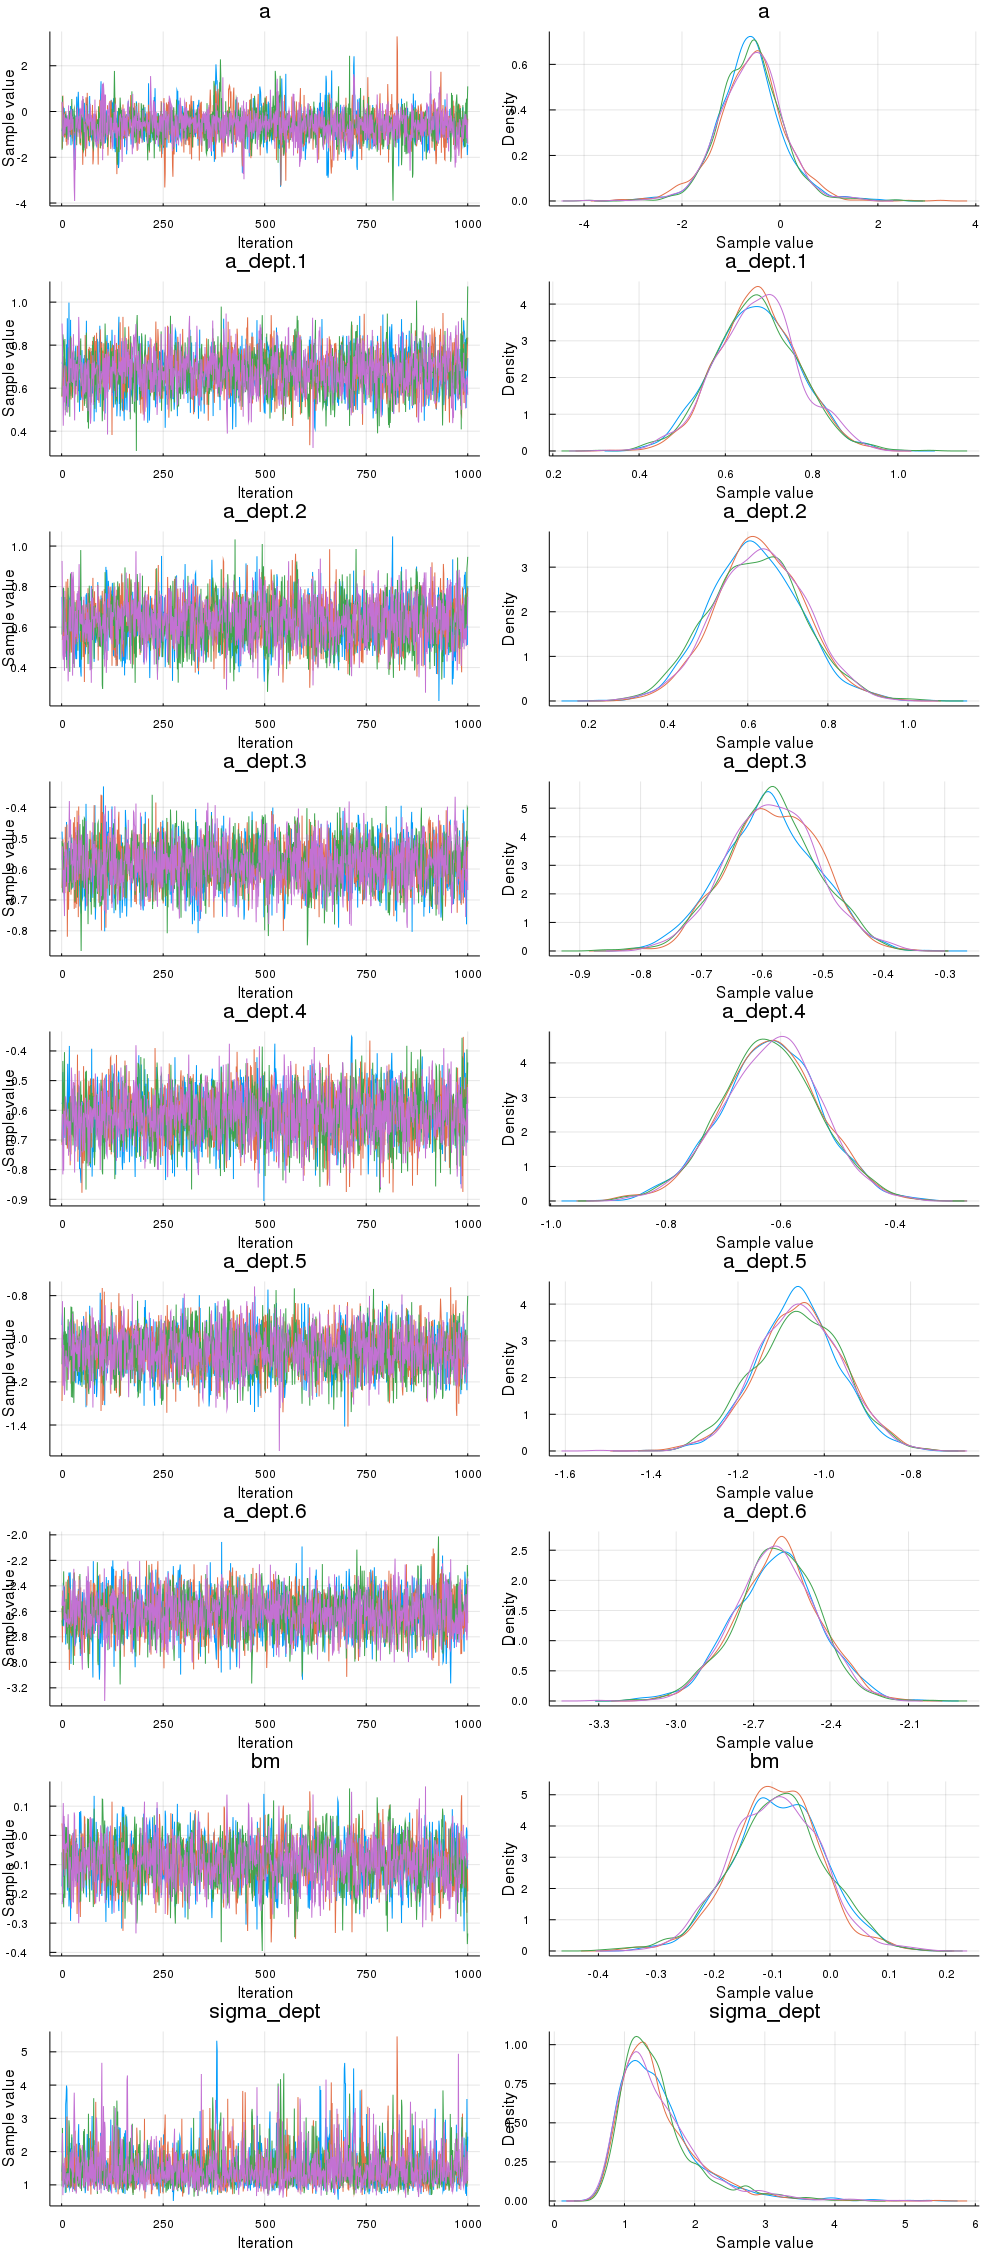

In [8]:
plot(chn)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*